# Text Mining Project 2 - Sentiment analysis & Topic modelling


*   Amar Music - r0665160
*   Guilherme Consul Soares de Bem - r0917829
*   Sounak Ghosh - r0914328
*   Shinichi Moribe - r0913014






## Importing Libraries and Data

In [1]:
# Import the required libraries
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



# Used for 1 Sentiment analysis
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Used for 2 topic modelling
from nltk.stem import  WordNetLemmatizer
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
from wordcloud import WordCloud




# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\souna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\souna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\souna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Download Data

In [4]:
# Function to download a file and get the filename from the headers
def download_file(url, output_file):
    response = requests.get(url, stream=True)

    # Check if the request was successful
    if response.status_code == 200:
        # Get the filename from the content disposition in the headers
        content_disposition = response.headers.get('content-disposition')

        if content_disposition:
            filename_match = re.search(r"filename\*=UTF-8''(.*)", content_disposition)
            if filename_match:
                filename = filename_match.group(1)
                filename = filename.replace('%', '_')  # Replace special characters
                output_file = filename
            else:
                print("Warning: Filename not found in content-disposition header.")

        # Save the content to the output file
        with open(output_file, 'wb') as f:
            for chunk in response.iter_content(chunk_size=128):
                f.write(chunk)

        return output_file
    else:
        print(f"Error: Failed to download file. Status code: {response.status_code}")
        return None

# loading the dataset
# File ID from the Google Drive link
imdb_file_id = '1RMNmvvAEtyJtCOvr9_CUfpFYSj1GdLLA'
abc_news_file_id = '16lbkHnIIm-4LFL1ETdSvsJTkvuBLuBKs'

# Output file name
imdb_file = 'IMDB Dataset.csv'
abc_file = 'abcnews-date-text.csv'

# Google Drive download link
imdb_url = f'https://drive.google.com/uc?id={imdb_file_id}'
abc_url = f'https://drive.google.com/uc?id={abc_news_file_id}'

# Download the files
downloaded_imdb_file = download_file(imdb_url, imdb_file)
downloaded_abc_file = download_file(abc_url, abc_file)

# Print or use the extracted filenames
print("IMDB Filename:", downloaded_imdb_file)
print("ABC News Filename:", downloaded_abc_file)

IMDB Filename: IMDB Dataset.csv
ABC News Filename: abcnews-date-text.csv


---
# 1. Sentiment Analysis


## Question 1
*Train a feedforward neural language model from scratch (you can choose the complexity of your model) that predicts the sentiment score (positive or negative) of a given review. To perform this task, the dataset needs to be split a priori in a 80-20 train-validation dataset, respectively, at random. The inputs of your feedforward neural network can be either word embedding (with vector dimension 100), or specific features, depending on your personal preferences. Remark: To perform this task, it can be that you need to perform some pre-processing steps.*

## Importing Data as Pandas Dataframe

In [5]:
df_imdb = pd.read_csv(imdb_file)
df_imdb.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

## Preprocessing

In [6]:
# Binarization of the target variable
df_imdb['sentiment_int'] = df_imdb['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Removing the punctuations and lower-casing the text
def preprocess_text(text):
    text = re.sub('<.*?>', '', text) #removing html tags
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator) #removing punctuations
    text = text.lower() #making the text lowercase
    return text

df_imdb['review_processed'] = df_imdb['review'].apply(preprocess_text)

# Tokenizing the text
df_imdb['word_tokens'] = df_imdb['review_processed'].apply(lambda x: word_tokenize(x))

#removing the stop words
stop_words = set(stopwords.words('english'))
df_imdb['word_tokens'] = df_imdb['word_tokens'].apply(lambda x: ' '.join([item for item in x if item not in stop_words]))

## Sorting common words

In [7]:
corpus =  [word for text in df_imdb['word_tokens'] for word in text.split()]
sorted_words = Counter(corpus).most_common()
vocab_to_int = {w:i+1 for i, (w,_) in enumerate(sorted_words)}

reviews_int = []
for text in df_imdb['word_tokens']:
    r = [vocab_to_int[word] for word in text.split()] #for each review, change the tokens to integers with the vocab_to_int dictionary
    reviews_int.append(r)

df_imdb['review int'] = reviews_int

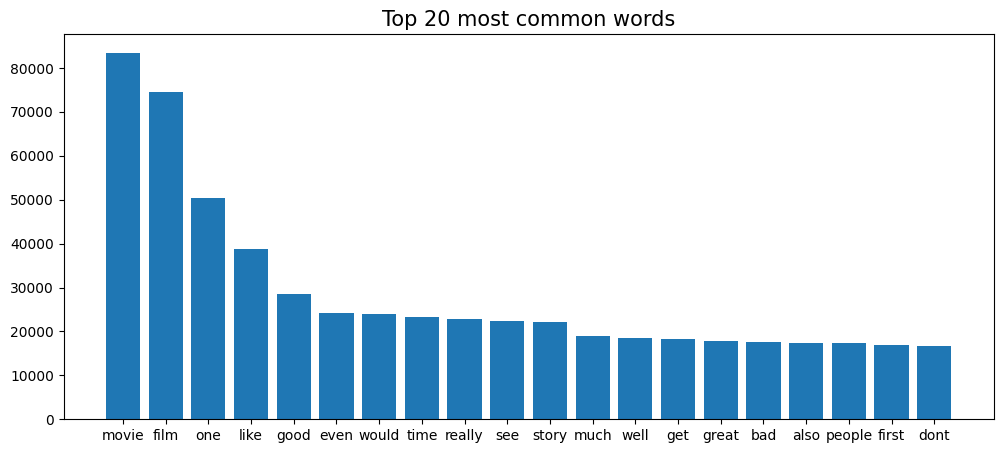

In [8]:
keys = []
values = []
for key, value in sorted_words[:20]:
    keys.append(key)
    values.append(value)

plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.title('Top 20 most common words', size=15)
plt.show()

## Padding function

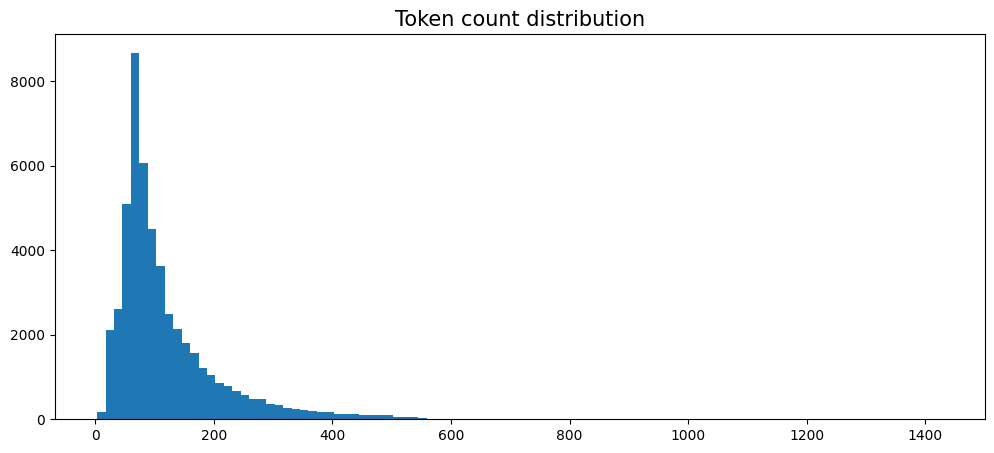

In [9]:
# count the # of tokens in each df_imdb['word_tokens']
df_imdb['length'] = df_imdb['review int'].apply(lambda x: len(x))

# plot the distribution
plt.figure(figsize=(12,5))
plt.hist(df_imdb['length'], bins=100)
plt.title('Token count distribution', size=15)
plt.show()

The size of the padding was tuned with reference to this distribution.

In [10]:
def Padding(review_int, seq_len): # seq_len is the maximum length of each review

    features = np.zeros((len(reviews_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return features

## Prepare train and test dataloaders

In [11]:
random_seed = 0
torch.manual_seed(random_seed)
seq_len = 400
features = Padding(reviews_int, seq_len)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Splitting the data into train, validation, and test sets
X_tmp, X_test, y_tmp, y_test = train_test_split(features, df_imdb['sentiment_int'].to_numpy(), test_size = 0.2, random_state = random_seed) # 20% for test set as suggested
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size = 0.2, random_state = random_seed)

# Move tensors to the specified device
X_train_tensor = torch.from_numpy(X_train).to(device)
X_val_tensor = torch.from_numpy(X_val).to(device)
X_test_tensor = torch.from_numpy(X_test).to(device)
y_train_tensor = torch.from_numpy(y_train).to(device)
y_val_tensor = torch.from_numpy(y_val).to(device)
y_test_tensor = torch.from_numpy(y_test).to(device)

# create tensor dataset
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# dataloaders
batch_size = 512

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=len(test_data))

To tune the model architecture and hyperparameters, we will split the data into train, validataion and test sets.

## Define feedforward neural network

In [13]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim * seq_len, hidden_dim),
            nn.Tanh(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, int(hidden_dim/2)),
            nn.Tanh(),
            nn.Dropout(0.4),
            nn.Linear(int(hidden_dim/2), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.squeeze()

## Train the model

In [14]:
vocab_size = len(vocab_to_int) + 1
embedding_dim = 100 # 100-dimensional embedding as suggested 
hidden_dim =512
epochs = 25

model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim)
print(f'number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
model = model.to(device)
criterion = nn.BCELoss() # Binary cross entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.002)

number of parameters: 42844197


c:\Users\souna\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    print(f'Epoch [{epoch + 1}/{epochs}], '
          f'Training Loss: {running_loss / len(train_loader):.4f}, ')

Epoch [1/25], Training Loss: 0.7403, 
Epoch [2/25], Training Loss: 0.6976, 
Epoch [3/25], Training Loss: 0.6913, 
Epoch [4/25], Training Loss: 0.6877, 
Epoch [5/25], Training Loss: 0.6855, 
Epoch [6/25], Training Loss: 0.6840, 
Epoch [7/25], Training Loss: 0.6837, 
Epoch [8/25], Training Loss: 0.6841, 
Epoch [9/25], Training Loss: 0.6849, 
Epoch [10/25], Training Loss: 0.6827, 
Epoch [11/25], Training Loss: 0.6820, 
Epoch [12/25], Training Loss: 0.6819, 
Epoch [13/25], Training Loss: 0.6789, 
Epoch [14/25], Training Loss: 0.6766, 
Epoch [15/25], Training Loss: 0.6747, 
Epoch [16/25], Training Loss: 0.6666, 
Epoch [17/25], Training Loss: 0.6269, 
Epoch [18/25], Training Loss: 0.4787, 
Epoch [19/25], Training Loss: 0.3518, 
Epoch [20/25], Training Loss: 0.2846, 
Epoch [21/25], Training Loss: 0.2397, 
Epoch [22/25], Training Loss: 0.1955, 
Epoch [23/25], Training Loss: 0.1683, 
Epoch [24/25], Training Loss: 0.1351, 
Epoch [25/25], Training Loss: 0.1179, 


## Evaluation with the validation set

In [16]:
# Evaluation on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy_percentage = 100 * correct / total
rounded_accuracy = round(accuracy_percentage)
print(f'Accuracy of the model on the {total} test reviews: {rounded_accuracy} %')

Accuracy of the model on the 8000 test reviews: 88 %


These hyperparameters are tuned with the validation dataset. The final model obtained an accuracy of 0.88

*   padding size: 400
*   model architecture: 2 hidden layers after embedding, , Tanh as activation functions, applying dropout
* batch size: 512
* epoch: 25
* optimizer: Adam

Although it achieved high accuracy, this model has 42 million trainable parameters, which require computational resources.
Additionally, applying padding with 400 tokens to achieve higher accuracy makes computation less efficient because of the sparse input vectors.

## Question 2
*Evaluate the performance of your trained neural network model by calculating the precision, recall and F1-score measurements on the validation dataset.*

## Evaluation with the test dataset

In [17]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_percentage = 100 * correct / total
rounded_accuracy = round(accuracy_percentage)
print(f'Accuracy of the model on the {total} test reviews: {rounded_accuracy} %')


print('classification report')
print(classification_report(labels.cpu(), predicted.cpu()))

Accuracy of the model on the 10000 test reviews: 87 %
classification report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5035
           1       0.86      0.88      0.87      4965

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



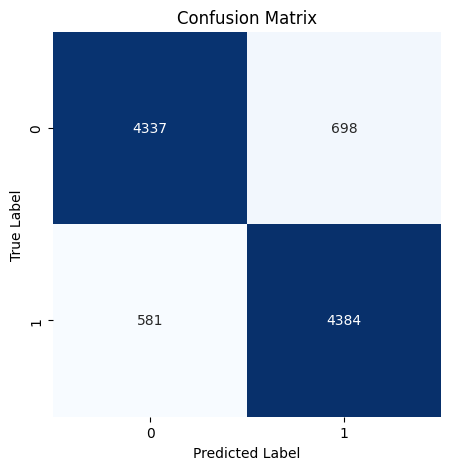

In [18]:

cm = confusion_matrix(labels.cpu(), predicted.cpu())
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


For the test data, the model achieved an accuracy of 0.87. Overfitting was not indicated.

Precision(=tp/(tp+fp)) means “How much of the predicted positives are we getting correct?”

Recall(=tp/(tp+fn)) means "how much of the positives did we predict as such", same as true positive rate.

F1-score (=2\*precision\*recall/(precision+recall)) is a metric combining precision and recall, especially used for imbalanced datasets.

The precision and recall when positive reviews are labeled as positive were 0.86 and 0.88. In addition, the F1-score was 0.87.
From these values and the confusion matrix, we can confirm the model predicts well without overfitting.


---
# 2 Topic Modelling

## Question 1
*Apply the Latent Semantic Analysis and Latent Dirichlet Allocation technique to study the topic focus of ABC’s news headlines. Characterize them by exploring the most frequent words in each topic.*

In [19]:
# loading the dataset

df_abc = pd.read_csv(abc_file)

# Convert 'publish date' to datetime format
df_abc['publish_date'] = pd.to_datetime(df_abc['publish_date'], format='%Y%m%d')
df_abc.head()

publish_date                                      headline_text
0   2003-02-19  aba decides against community broadcasting lic...
1   2003-02-19     act fire witnesses must be aware of defamation
2   2003-02-19     a g calls for infrastructure protection summit
3   2003-02-19           air nz staff in aust strike for pay rise
4   2003-02-19      air nz strike to affect australian travellers

In [20]:
# checking for missing values

df_abc.isnull().sum() # no missing values

publish_date     0
headline_text    0
dtype: int64

## Pre-processing

In [22]:
nlp = spacy.load('en_core_web_sm')


def filter_text(text):
    # Process the text using spaCy
    doc = nlp(text)

    # Define the POS tags to keep
    pos_to_keep = ['NOUN', 'PROPN', 'ADJ', 'ADV']

    # Filter words based on POS and remove stopwords
    filtered_words = [token.text for token in doc if token.pos_ in pos_to_keep and token.text.lower() not in STOP_WORDS]

    # Join the filtered words back into a sentence
    filtered_text = ' '.join(filtered_words)

    # lemmatize the text　(to examine the frequency of the words, lemmatization is better to be done)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in filtered_text.split()]

    # join the lemmatized tokens
    filtered_text = ' '.join(tokens)

    return filtered_text

df_abc['headline_text'] = df_abc['headline_text'].apply(filter_text)  # This pre-process takes a while to run

## Create a dictionary and corpus for LDA and LSA

In [23]:
# Create a dictionary and a corpus
dictionary = corpora.Dictionary(df_abc['headline_text'].apply(lambda x: x.split()))
corpus = [dictionary.doc2bow(text.split()) for text in df_abc['headline_text']]

In [24]:
# Define the number of topics
number_of_topics = 10

## LDA for all datasets

In [25]:
# Apply Latent Dirichlet Allocation (LDA) for the current time period
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=number_of_topics, random_state=42)

# Display top words for each topic for the current time period
topics_period = lda_model.show_topics(num_topics=number_of_topics, num_words=10, formatted=False)
for topic_id, words in topics_period:
    top_words = [word for word, _ in words]
    print(f"Topic #{topic_id + 1}: {top_words}")

Topic #1: ['australia', 'queensland', 'china', 'coronavirus', 'home', 'canberra', 'car', 'andrew', 'afl', 'final']
Topic #2: ['police', 'melbourne', 'fire', 'news', 'border', 'scott', 'house', 'national', 'hotel', 'uk']
Topic #3: ['victoria', 'vaccine', 'covid', 'lockdown', 'new', 'school', 'brisbane', 'bushfire', 'federal', 'care']
Topic #4: ['nsw', 'election', 'court', 'donald', 'state', 'world', 'murder', 'trial', 'time', 'attack']
Topic #5: ['trump', 'death', 'family', 'change', 'coronavirus', 'market', 'wa', 'biden', 'open', 'protest']
Topic #6: ['sydney', 'woman', 'day', 'child', 'victorian', 'police', 'regional', 'man', 'dead', 'street']
Topic #7: ['case', 'covid', 'coronavirus', 'health', 'coast', 'life', 'premier', 'live', 'test', 'gold']
Topic #8: ['australian', 'government', 'south', 'morrison', 'worker', 'business', 'island', 'coronavirus', 'labor', 'christmas']
Topic #9: ['restriction', 'sa', 'indigenous', 'community', 'north', 'water', 'new', 'council', 'park', 'qld']
Top

We can characterize the topics as follows.
* Topic #1: National news and Sports
* Topic #2: Law and Crime
* Topic #3: Victoria state, COVID-19 and Education
* Topic #4: NSW(New South Wales) Events and election
* Topic #5: International politics, COVID-19, and Market
* Topic #6: Local Events in Sydney and Children
* Topic #7: COVID-19, Health and Life
* Topic #8: National Government and Business
* Topic #9: Restrictions and agriculture
* Topic #10: New Events and COVID-19

##  LSA for all datasets

In [26]:
# Apply Latent Semantic Analysis (LSA)
lsa_model = LsiModel(corpus, id2word=dictionary, num_topics=number_of_topics)

# Display top words for each topic
topics_period = lsa_model.show_topics(num_topics=number_of_topics, num_words=10, formatted=False)
for topic_id, words in topics_period:
    top_words = [word for word, _ in words]
    print(f"Topic #{topic_id + 1}: {top_words}")

Topic #1: ['police', 'man', 'new', 'death', 'court', 'car', 'murder', 'crash', 'woman', 'officer']
Topic #2: ['new', 'police', 'council', 'year', 'zealand', 'man', 'australia', 'plan', 'case', 'law']
Topic #3: ['man', 'police', 'court', 'murder', 'charge', 'death', 'new', 'child', 'guilty', 'sydney']
Topic #4: ['council', 'govt', 'plan', 'new', 'water', 'fire', 'australia', 'qld', 'man', 'court']
Topic #5: ['govt', 'council', 'plan', 'water', 'qld', 'vic', 'australia', 'sa', 'fire', 'rate']
Topic #6: ['australia', 'council', 'coronavirus', 'court', 'australian', 'govt', 'woman', 'man', 'fire', 'rural']
Topic #7: ['coronavirus', 'court', 'fire', 'australia', 'man', 'woman', 'covid', 'council', 'victoria', 'govt']
Topic #8: ['court', 'coronavirus', 'plan', 'australia', 'council', 'rural', 'australian', 'world', 'case', 'cup']
Topic #9: ['plan', 'australia', 'council', 'coronavirus', 'fire', 'world', 'australian', 'cup', 'govt', 'rural']
Topic #10: ['fire', 'court', 'plan', 'crash', 'aust

We can characterize the topics as follows.
* Topic #1: Police incidents and Death
* Topic #2: Law and Government
* Topic #3: Police incidents and Man
* Topic #4: Government and Fire
* Topic #5: Government
* Topic #6: National news, Government and COVID-19
* Topic #7: COVID-19
* Topic #8: Legal proceedings and Rural news
* Topic #9:  National plans and Fire
* Topic #10: Fires and Plans

In the LSA model, words such as 'council', 'police', and 'plan' are found in many topics. This makes it difficult to distinguish between topics.

This may be because the LSA model aggregates words with high similarity based on co-occurrence into the same topics. Therefore, words such as 'council', 'police', and 'plan' are easily used with other words and chosen for multiple topics.

## Question 2
*How do these topics evolve through time in the ABC news headlines?*

To analyze the evolution of the topic, we applied two approaches as follows:
1. Calculate the dominant topic of LDA on all data (Question 1) for each headline, then examine the frequent words yearly for each topic 
2. Conduct the LDA and LSA on each month and year and check how the topics have evolved over the entire period

## (Approach 1) Check how each LDA topic obtained in Question 1 has changed over time.

## Find a dominant topic for each headline

In [27]:
# Create an empty DataFrame to store dominant topics
dominant_topics = []

# Get main topic in each document
for i, row_list in enumerate(lda_model[corpus]):

    row = sorted(row_list, key=lambda x: (x[1]), reverse=True)

    # Get the Dominant topic
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            dominant_topics.append({'Dominant_Topic': int(topic_num+1)})
        else:
            break

# Create a DataFrame from the list
topics_df = pd.DataFrame(dominant_topics)

# add it to the original dataframe
df_abc['Dominant_Topic'] = topics_df['Dominant_Topic']

df_abc.head()


publish_date                       headline_text  Dominant_Topic
0   2003-02-19  aba community broadcasting licence               9
1   2003-02-19       fire witness aware defamation               2
2   2003-02-19  g infrastructure protection summit               8
3   2003-02-19   air nz staff aust strike pay rise               7
4   2003-02-19         air nz australian traveller               8

## Plot the yearly distribution of topics

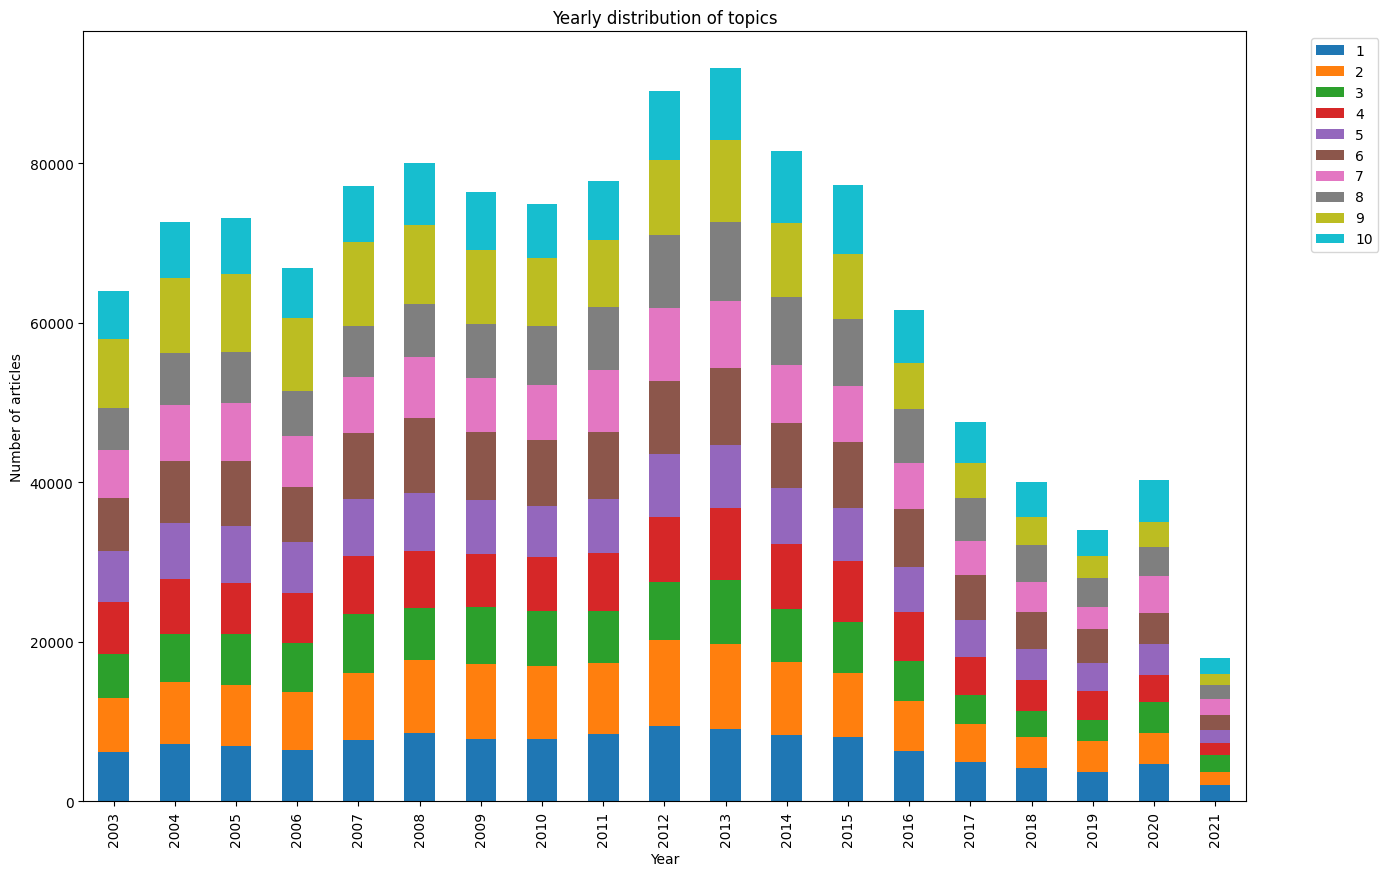

In [28]:
# plot the yearly distribution of topics
df_abc.groupby(df_abc['publish_date'].dt.year)['Dominant_Topic'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(15, 10))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Yearly distribution of topics')
plt.show()


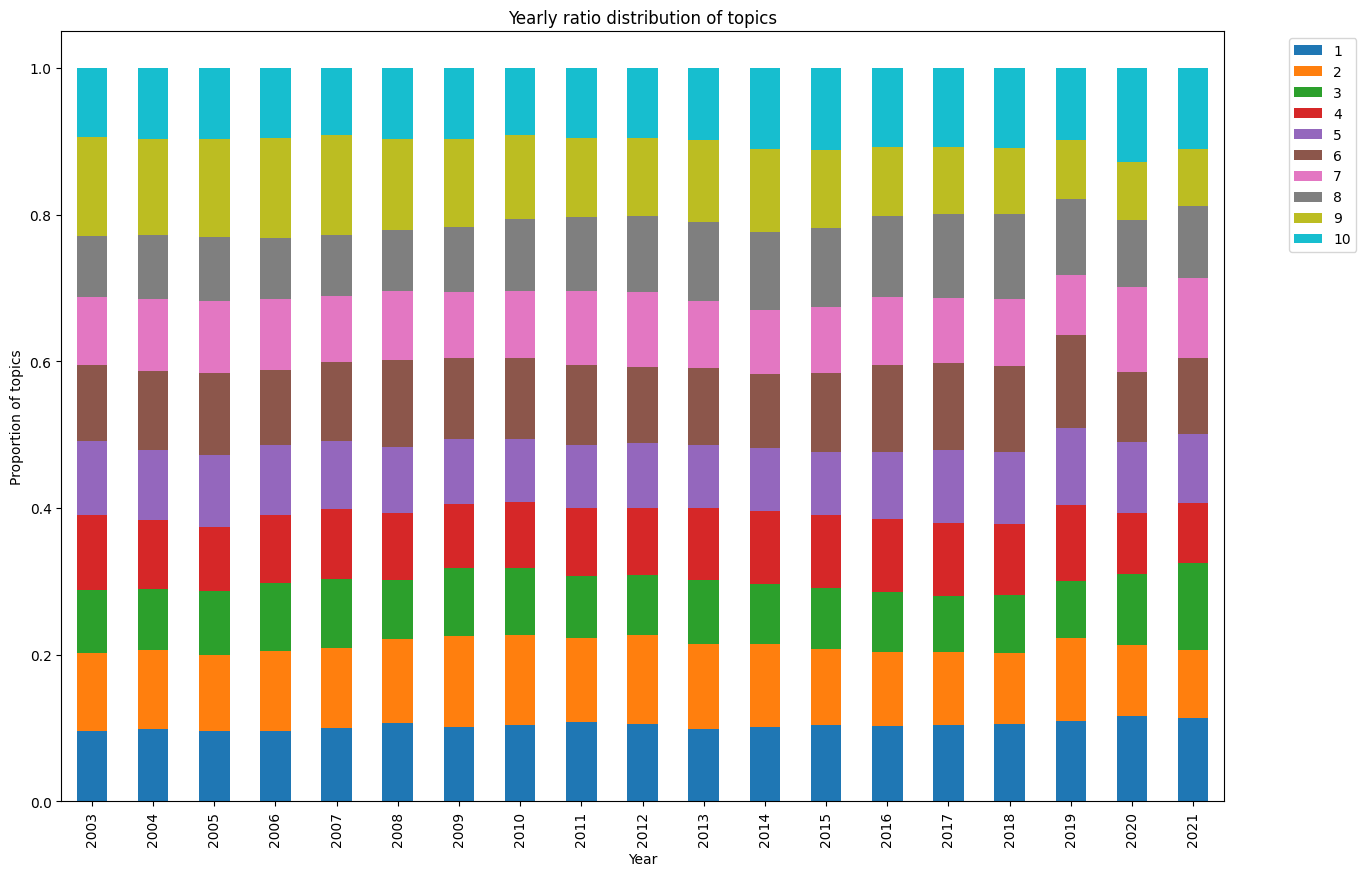

In [29]:
# Calculate the ratio of topics
topic_ratio = df_abc.groupby(df_abc['publish_date'].dt.year)['Dominant_Topic'].value_counts(normalize=True).unstack()

# Plot the yearly distribution of topics
topic_ratio.plot(kind='bar', stacked=True, figsize=(15, 10))

# Add legend and labels
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Year')
plt.ylabel('Proportion of topics')
plt.title('Yearly ratio distribution of topics')

# Show the plot
plt.show()


While the number of headlines peaked in 2013 and has been decreasing, no substantial changes occurred with respect to the ratio of each LDA topic. This indicates that temporary news events such as Covid-19 were not categorized under only one topic.

## Plot wordcloud for each topic for each year

In [30]:
# plot wordcloud for each topic for each year
def plot_topic_wordcloud(topic):
    for j in range(2003, 2022):
        df = df_abc[(df_abc['publish_date'].dt.year == j) & (df_abc['Dominant_Topic'] == topic)]
        plt.subplot(20, 2, j-2002)
        word_frequencies = Counter(df['headline_text'].apply(lambda x: x.split()).sum())
        im = WordCloud().generate_from_frequencies(word_frequencies)
        plt.imshow(im)
        plt.axis("off")
        plt.title("Topic #" + str(topic) + ' year ' + str(j))

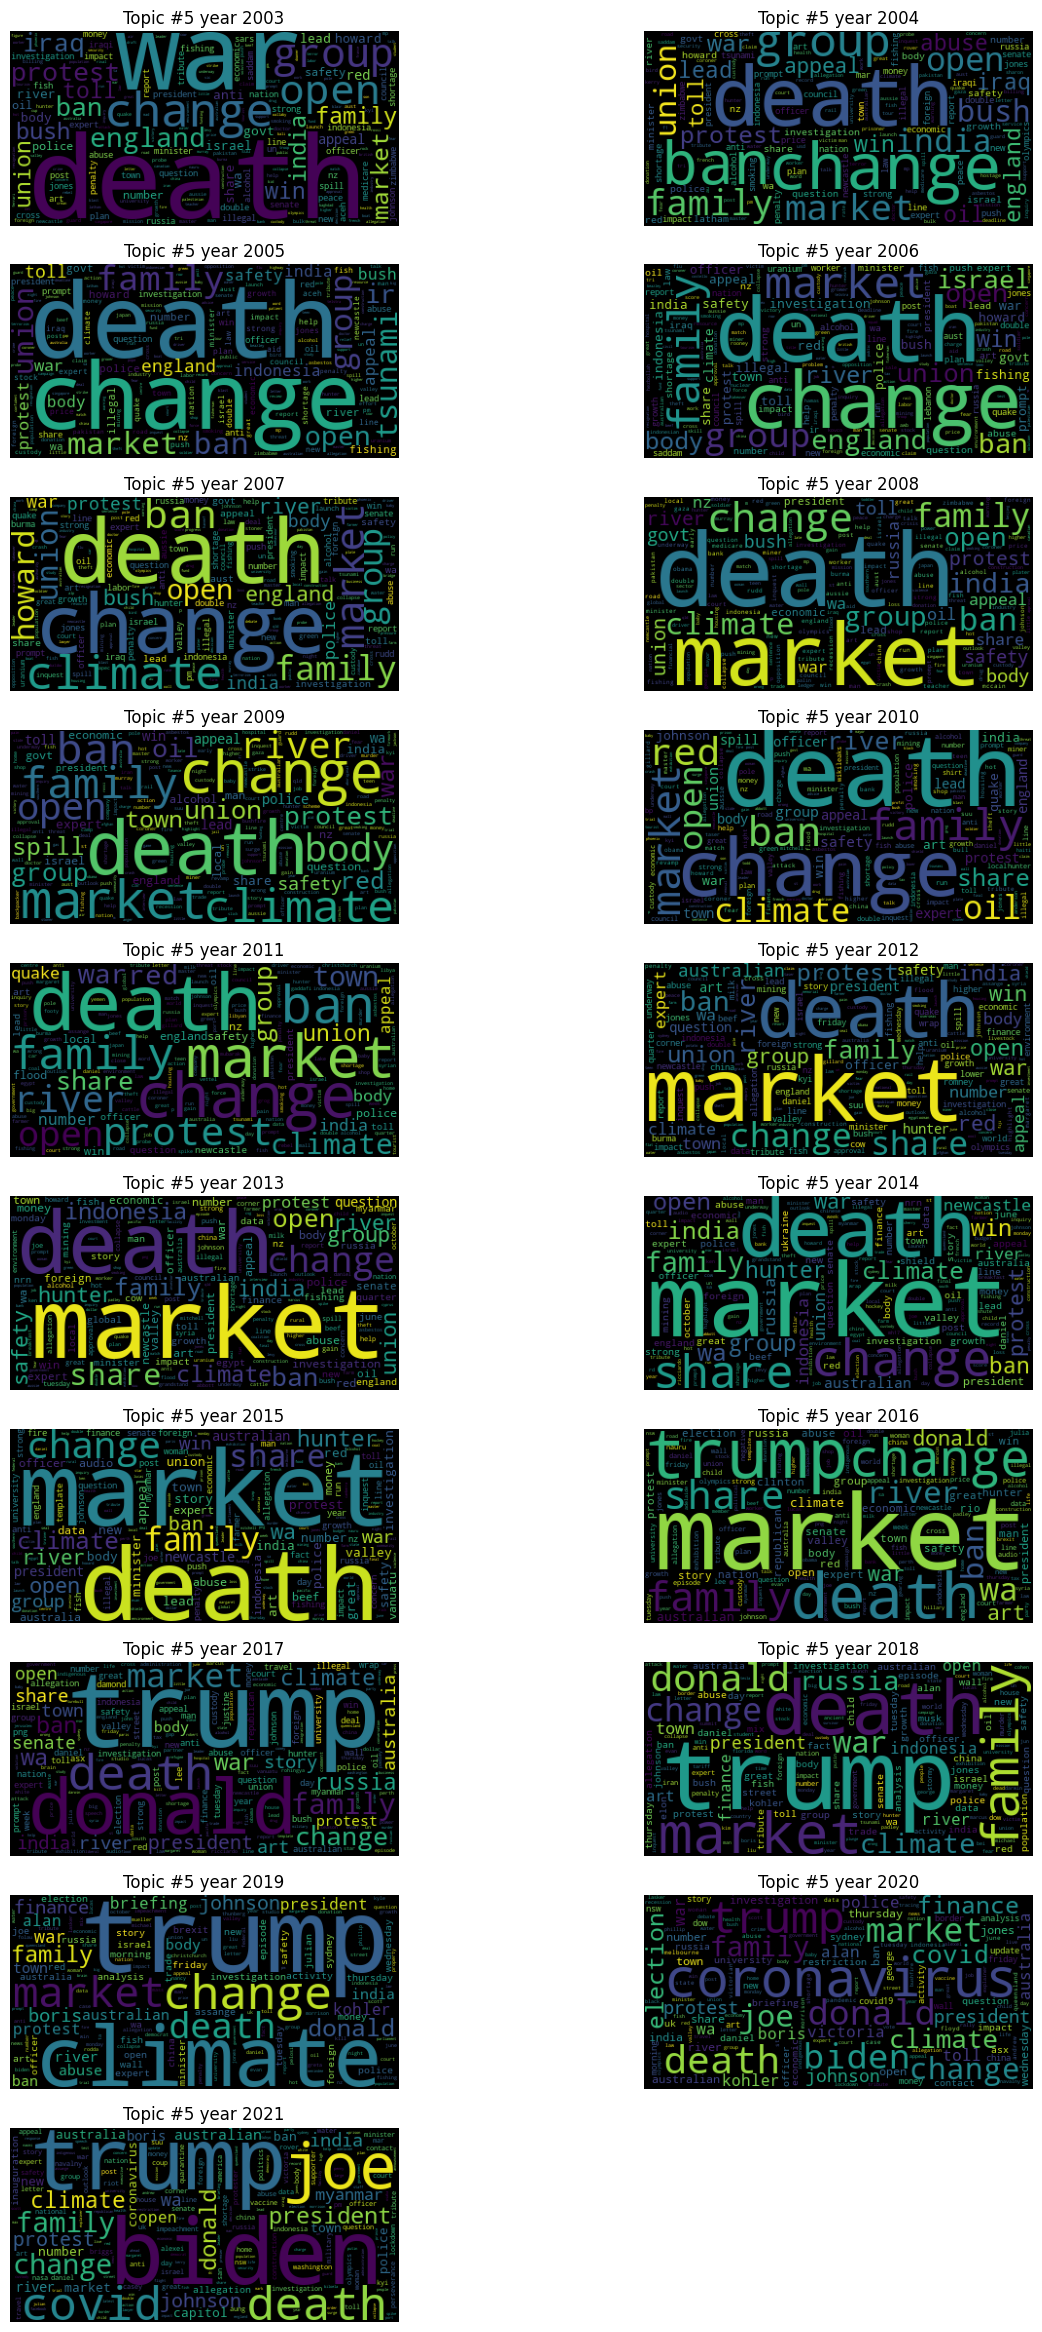

In [31]:
plt.figure(figsize=(15, 60))
plot_topic_wordcloud(5)

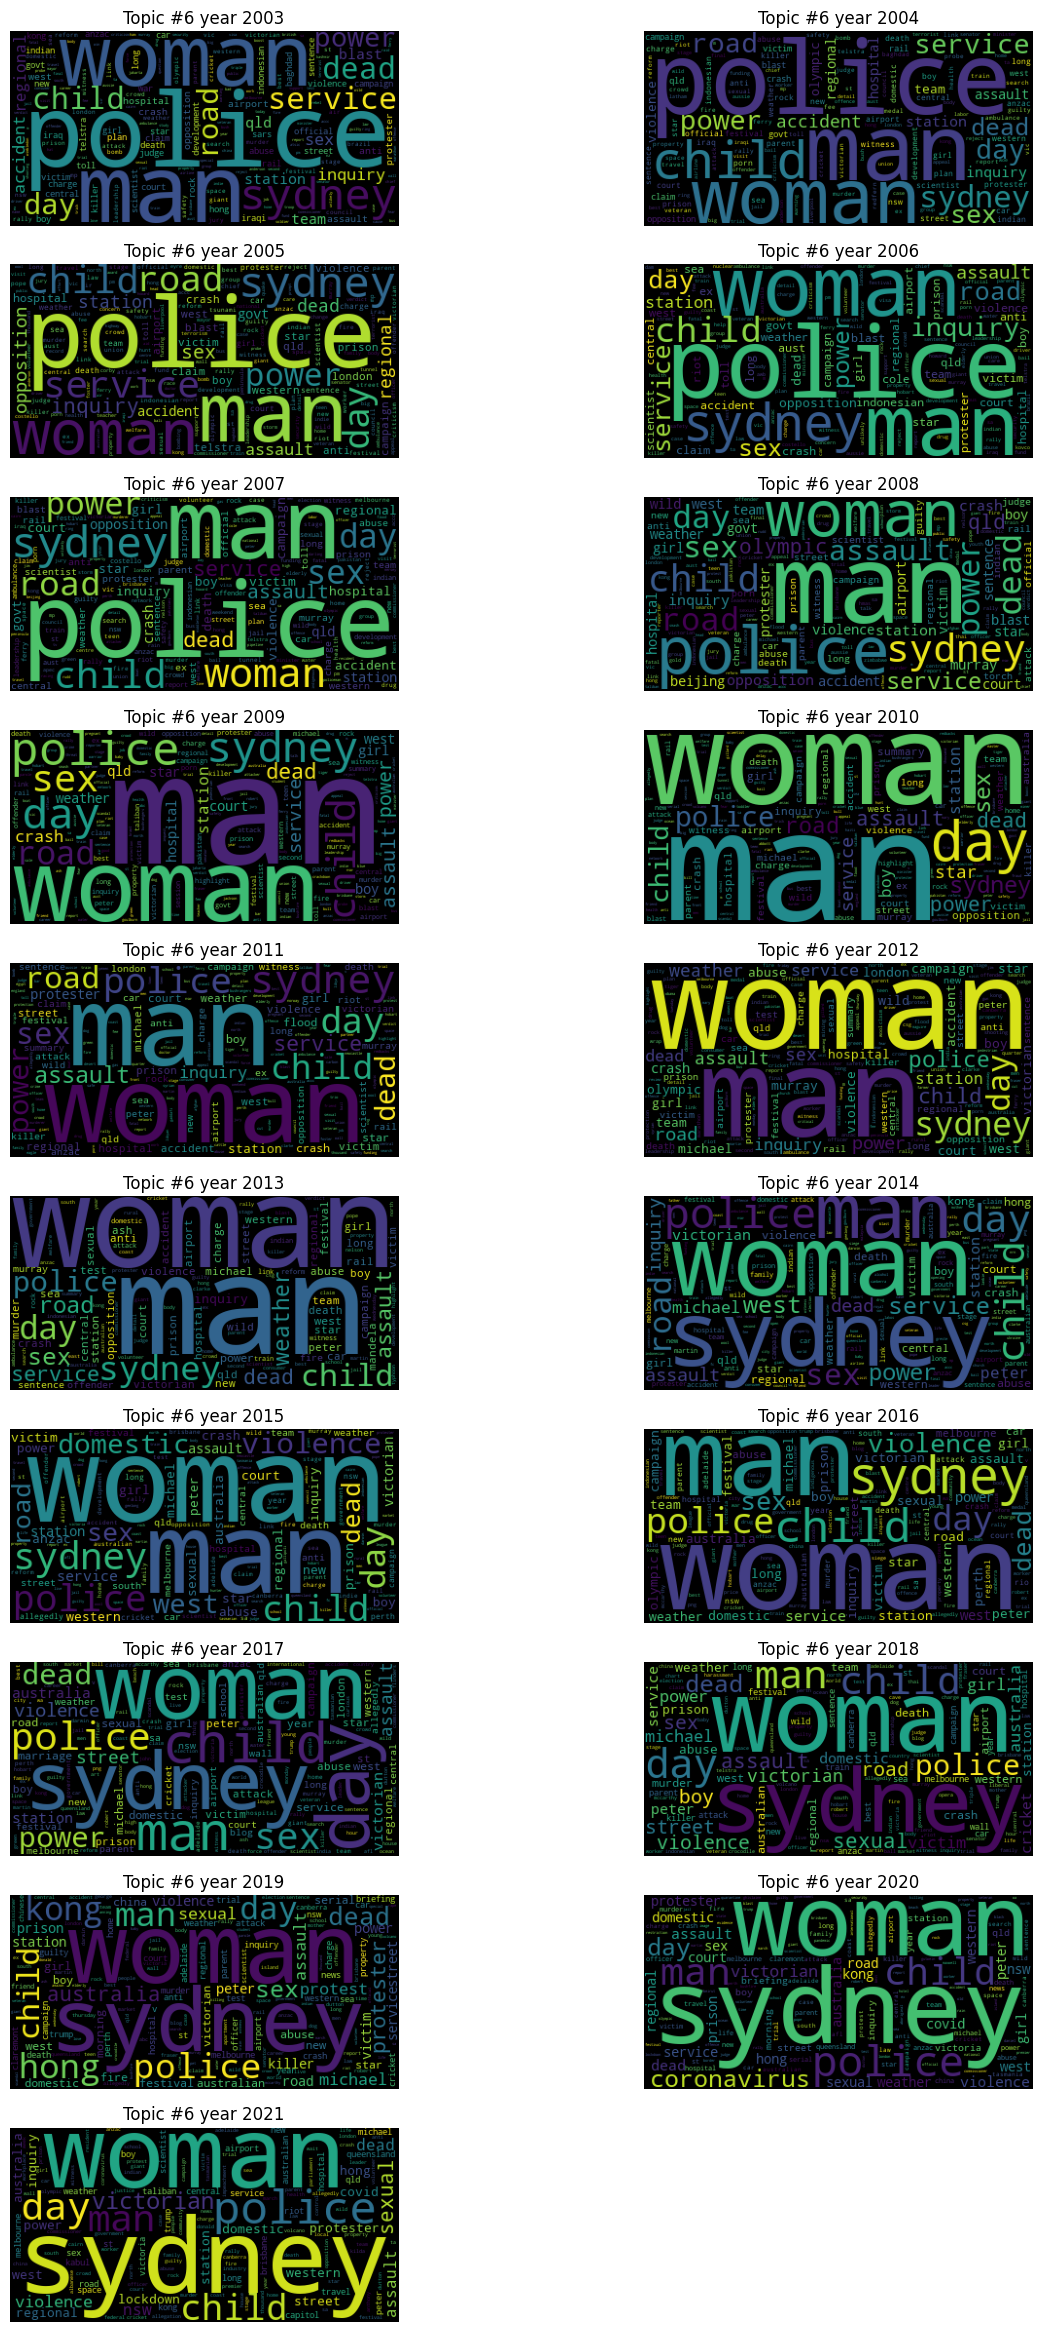

In [32]:
plt.figure(figsize=(15, 60))
plot_topic_wordcloud(6)

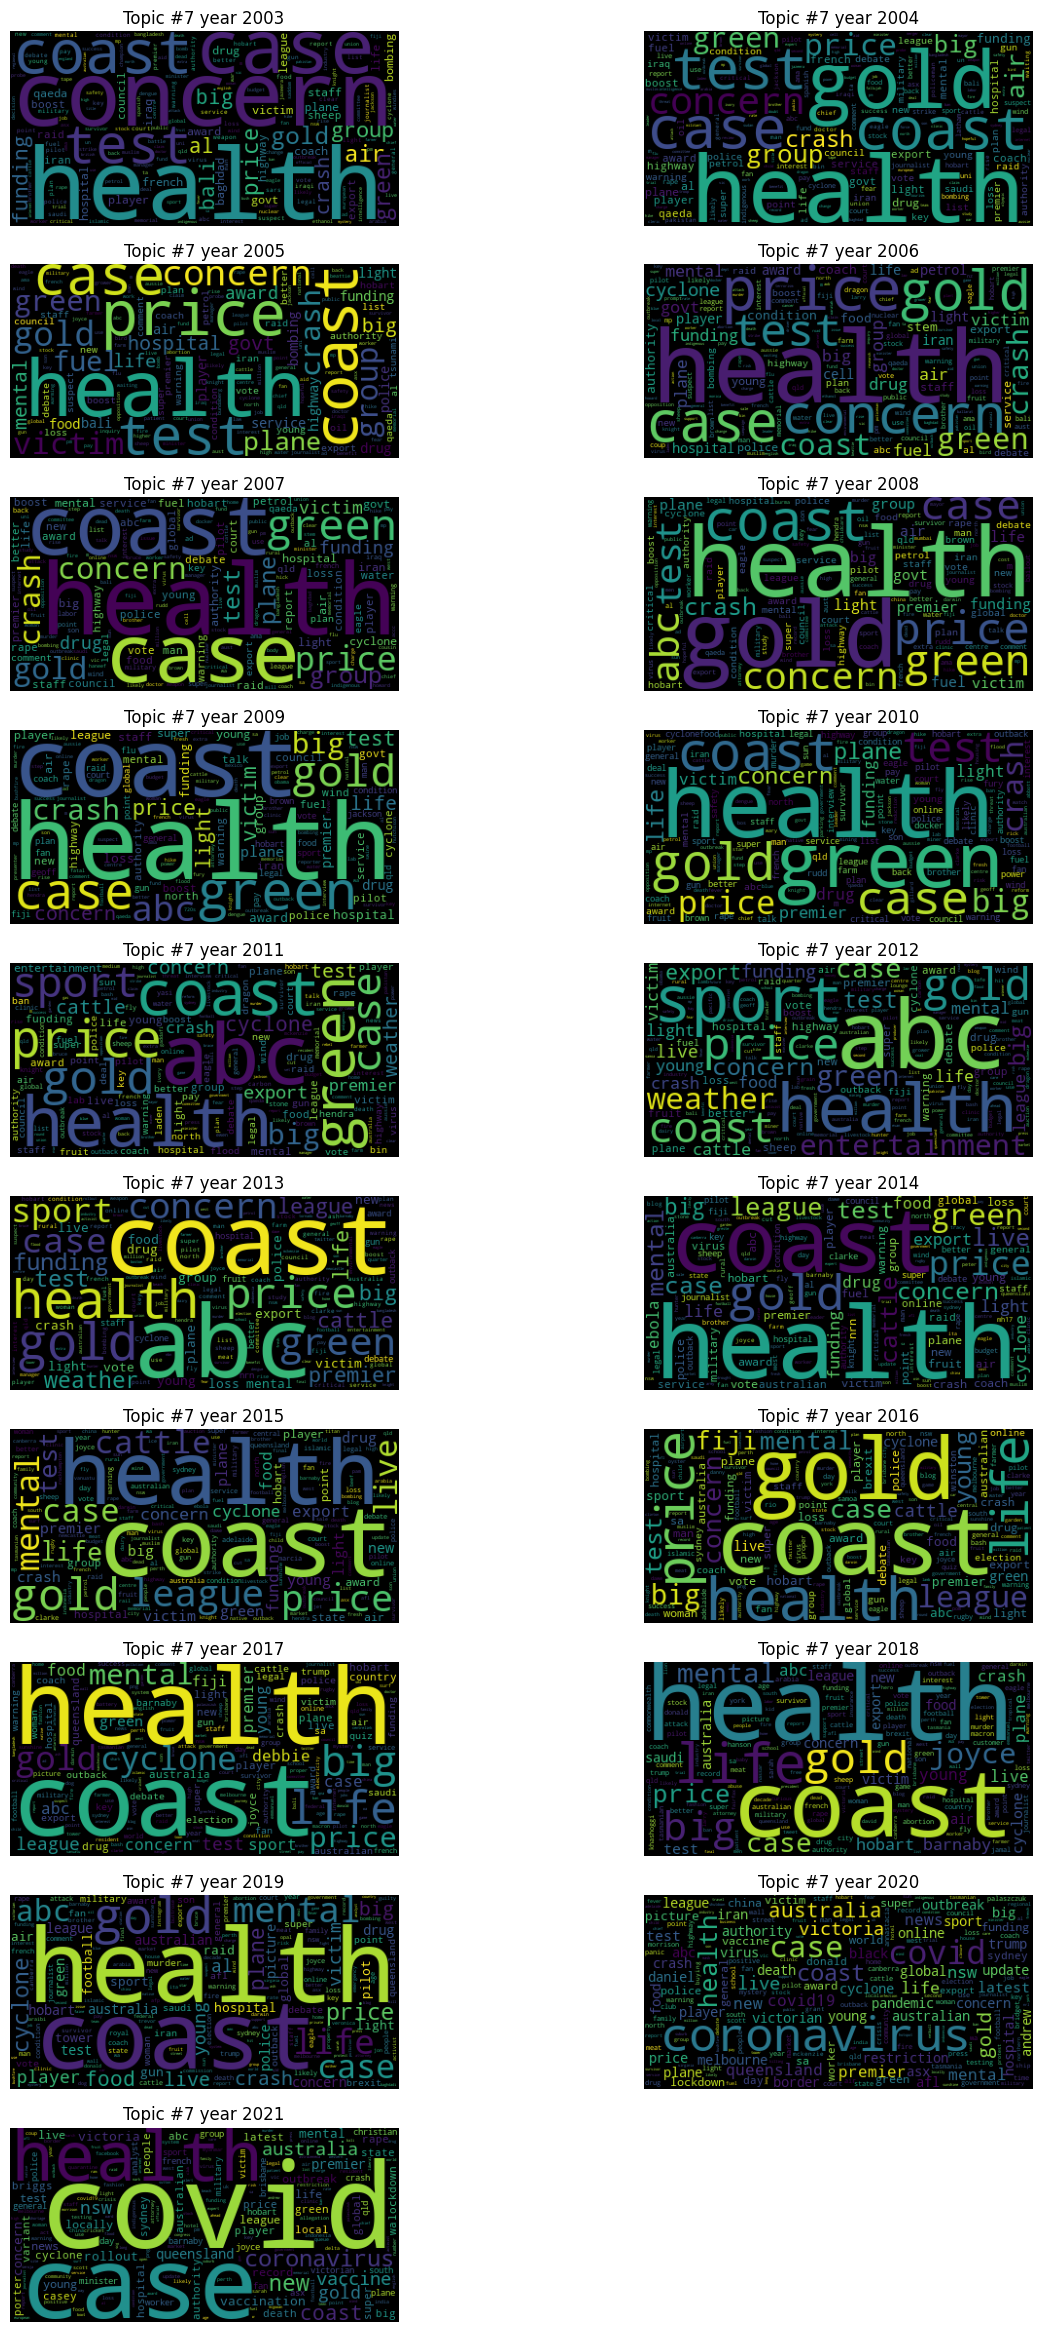

In [33]:
plt.figure(figsize=(15, 60))
plot_topic_wordcloud(7)

The WordClouds demonstrate how the frequent words in the headlines with the same dominant topic have changed.

As the figures have shown, some topics, such as topic 6, have stable WordClouds, which indicates that the contents of these topics haven't changed

On the other hand, some topics, such as topic 5 and topic 7 have shown different WordClouds yearly. These topics include more trendy words, like "covid" and "Trump".

## (Approach 2) Split the dataset monthly/yearly and check how the topics of LDA/LSA have changed

## Performing LDA for each month

In [34]:
# Define the number of topics
number_of_topics = 10
df_abc['year_month'] = df_abc['publish_date'].dt.to_period('M')

for period in sorted(df_abc['year_month'].unique()):
    # Filter headlines for the current time period
    headlines_period = df_abc[df_abc['year_month'] == period]['headline_text']

    # Create a corpus for the current time period
    corpus_period = [dictionary.doc2bow(text.split()) for text in headlines_period]

    # Apply Latent Dirichlet Allocation (LDA) for the current time period
    lda_model = LdaModel(corpus_period, id2word=dictionary, num_topics=number_of_topics, random_state=42)

    # Display top words for each topic for the current time period
    print(f"\nTop 10 Topics for {period}:")
    topics_period = lda_model.show_topics(num_topics=number_of_topics, num_words=10, formatted=False)
    for topic_id, words in topics_period:
        top_words = [word for word, _ in words]
        print(f"Topic #{topic_id + 1}: {top_words}")


Top 10 Topics for 2003-02:
Topic #1: ['row', 'star', 'card', 'woman', 'council', 'final', 'turkey', 'car', 'uk', 'meeting']
Topic #2: ['police', 'iraq', 'govt', 'new', 'good', 'liverpool', 'claim', 'rain', 'ta', 'un']
Topic #3: ['end', 'resident', 'centre', 'brisbane', 'plan', 'moya', 'man', 'war', 'tourist', 'bos']
Topic #4: ['teen', 'gm', 'rainfall', 'nsw', 'world', 'election', 'council', 'wagga', 'approach', 'attention']
Topic #5: ['police', 'death', 'plan', 'oil', 'new', 'union', 'rain', 'price', 'howard', 'river']
Topic #6: ['dead', 'child', 'freak', 'accident', 'tv', 'moratorium', 'woman', 'centre', 'issue', 'detention']
Topic #7: ['man', 'coast', 'council', 'victim', 'woman', 'life', 'vic', 'iraq', 'lead', 'govt']
Topic #8: ['darling', 'fourth', 'court', 'water', 'business', 'down', 'island', 'train', 'protection', 'transport']
Topic #9: ['korea', 'north', 'govt', 'water', 'restriction', 'real', 'n', 'pakistan', 'rural', 'collision']
Topic #10: ['rate', 'potential', 'new', 'yea

## Performing LSA for each month

In [35]:
number_of_topics = 10  # Adjust the number of topics as needed


df_abc['year_month'] = df_abc['publish_date'].dt.to_period('M')

# Initialize an empty LSA model
lsa_model = None

# Iterate through time periods
for period in sorted(df_abc['year_month'].unique()):
    # Filter headlines for the current time period
    headlines_period = df_abc[df_abc['year_month'] == period]['headline_text']

    # Create a corpus for the current time period
    corpus_period = [dictionary.doc2bow(text.split()) for text in headlines_period]

    # Apply Latent Semantic Analysis (LSA) for the current time period
    lsa_model = LsiModel(corpus_period, id2word=dictionary, num_topics=number_of_topics)

    # Display top words for each topic for the current time period
    print(f"\nTop 10 Topics for {period}:")
    topics_period = lsa_model.show_topics(num_topics=number_of_topics, num_words=10, formatted=False)
    for topic_id, words in topics_period:
        top_words = [word for word, _ in words]
        print(f"Topic #{topic_id + 1}: {top_words}")


Top 10 Topics for 2003-02:
Topic #1: ['police', 'man', 'court', 'murder', 'death', 'charge', 'probe', 'govt', 'new', 'rain']
Topic #2: ['rain', 'water', 'iraq', 'council', 'drought', 'police', 'govt', 'new', 'restriction', 'farmer']
Topic #3: ['iraq', 'new', 'rain', 'un', 'council', 'war', 'resolution', 'water', 'govt', 'missile']
Topic #4: ['man', 'police', 'court', 'murder', 'probe', 'charge', 'hospital', 'rain', 'cannabis', 'iraq']
Topic #5: ['govt', 'new', 'iraq', 'council', 'fire', 'plan', 'vic', 'nsw', 'police', 'rain']
Topic #6: ['council', 'iraq', 'rain', 'new', 'govt', 'plan', 'land', 'security', 'water', 'resolution']
Topic #7: ['new', 'govt', 'iraq', 'fire', 'council', 'missile', 'resolution', 'korea', 'war', 'court']
Topic #8: ['fire', 'korea', 'govt', 'north', 'missile', 'death', 'new', 'subway', 'iraq', 'downer']
Topic #9: ['court', 'man', 'plan', 'water', 'charge', 'new', 'death', 'korea', 'atsic', 'hospital']
Topic #10: ['water', 'rain', 'court', 'plan', 'restriction',

The two above outputs lists all the top 10 topics found for each month from 2003 to 2021 using LDA and LSA models. Upon some reading of the selected topics, a similarity is found between both models, but there are many topics to be analysed in more depth when using the monthly division, so a yearly division seems more appropriate.

## Performing LDA for each year

In [36]:
number_of_topics = 10
df_abc['year'] = df_abc['publish_date'].dt.to_period('Y')

for period in sorted(df_abc['year'].unique()):
    # Filter headlines for the current time period
    headlines_period = df_abc[df_abc['year'] == period]['headline_text']

    # Create a corpus for the current time period
    corpus_period = [dictionary.doc2bow(text.split()) for text in headlines_period]

    # Apply Latent Dirichlet Allocation (LDA) for the current time period
    lda_model = LdaModel(corpus_period, id2word=dictionary, num_topics=number_of_topics, random_state=42)

    # Display top words for each topic for the current time period
    print(f"\nTop 10 Topics for {period}:")
    topics_period = lda_model.show_topics(num_topics=number_of_topics, num_words=10, formatted=False)
    for topic_id, words in topics_period:
        top_words = [word for word, _ in words]
        print(f"Topic #{topic_id + 1}: {top_words}")


Top 10 Topics for 2003:
Topic #1: ['man', 'report', 'charge', 'fire', 'home', 'australia', 'woman', 'car', 'leader', 'court']
Topic #2: ['police', 'probe', 'murder', 'melbourne', 'security', 'aussie', 'iraq', 'industry', 'deal', 'tourism']
Topic #3: ['plan', 'centre', 'mp', 'aid', 'drought', 'search', 'new', 'support', 'fund', 'resident']
Topic #4: ['world', 'cup', 'court', 'attack', 'nsw', 'public', 'trial', 'decision', 'iraqi', 'appeal']
Topic #5: ['death', 'group', 'england', 'india', 'bush', 'union', 'safety', 'ban', 'family', 'market']
Topic #6: ['sydney', 'service', 'police', 'road', 'child', 'power', 'blast', 'dead', 'opposition', 'day']
Topic #7: ['health', 'case', 'test', 'air', 'funding', 'iran', 'coast', 'green', 'gold', 'award']
Topic #8: ['job', 'law', 'christmas', 'worker', 'australian', 'bank', 'fear', 'south', 'labor', 'title']
Topic #9: ['govt', 'council', 'water', 'sa', 'plan', 'indigenous', 'vic', 'new', 'pakistan', 'talk']
Topic #10: ['new', 'year', 'high', 'rate',

The evolution of topics in ABC Australia news over the years reveals dynamic shifts in focus and concerns. In 2003, significant themes included the Iraq War, drought, and international relations. As the years progressed, topics diversified to encompass issues such as natural disasters, political developments, and societal concerns. In 2009, there was an increased emphasis on economic issues and the global financial crisis. The years that followed saw a recurring focus on climate change, bushfires, and political events, with 2019 highlighting issues like the Australian bushfire emergency and climate change protests. In 2020, political topics such as the USA presidential run of Biden and Trump was covered. Moreover, the onset of 2020 brought a new set of challenges, including the COVID-19 pandemic and its associated impacts, which continued to be a topic in 2021, together with Australian political news. Throughout this period, consistent topics include government policies, health, international relations, and environmental concerns. The dynamic nature of the news topics reflects the evolving landscape of global and local events, emphasizing the responsiveness of media coverage to the changing socio-political and environmental context.

## Performing LSA for each year

In [37]:
# Initialize an empty LSA model
lsa_model = None

# Iterate through time periods
for period in sorted(df_abc['year'].unique()):
    # Filter headlines for the current time period
    headlines_period = df_abc[df_abc['year'] == period]['headline_text']

    # Create a corpus for the current time period
    corpus_period = [dictionary.doc2bow(text.split()) for text in headlines_period]

    # Apply Latent Semantic Analysis (LSA) for the current time period
    lsa_model = LsiModel(corpus_period, id2word=dictionary, num_topics=number_of_topics)

    # Display top words for each topic for the current time period
    print(f"\nTop 10 Topics for {period}:")
    topics_period = lsa_model.show_topics(num_topics=number_of_topics, num_words=10, formatted=False)
    for topic_id, words in topics_period:
        top_words = [word for word, _ in words]
        print(f"Topic #{topic_id + 1}: {top_words}")


Top 10 Topics for 2003:
Topic #1: ['police', 'man', 'govt', 'new', 'probe', 'death', 'court', 'murder', 'car', 'charge']
Topic #2: ['govt', 'new', 'police', 'plan', 'council', 'vic', 'qld', 'nsw', 'sa', 'iraq']
Topic #3: ['new', 'govt', 'council', 'police', 'plan', 'iraq', 'zealand', 'vic', 'year', 'law']
Topic #4: ['man', 'court', 'police', 'charge', 'murder', 'new', 'car', 'crash', 'council', 'hospital']
Topic #5: ['council', 'plan', 'new', 'govt', 'man', 'iraq', 'water', 'merger', 'concern', 'fund']
Topic #6: ['iraq', 'war', 'council', 'attack', 'un', 'troop', 'soldier', 'report', 'new', 'bush']
Topic #7: ['world', 'cup', 'final', 'iraq', 'australia', 'rugby', 'new', 'england', 'man', 'council']
Topic #8: ['plan', 'council', 'iraqi', 'govt', 'group', 'new', 'court', 'water', 'world', 'iraq']
Topic #9: ['court', 'sars', 'war', 'man', 'death', 'iraq', 'fire', 'iraqi', 'concern', 'health']
Topic #10: ['war', 'anti', 'sars', 'court', 'protest', 'death', 'iraq', 'fire', 'protester', 'co

The output of the Latent Semantic Analysis (LSA) model for each year also provides a snapshot of the key topics discussed in the news during those periods. Each year's top 10 topics highlight recurring themes and evolving trends in a similar way to the LDA output.

Both the LDA and LSA outputs reveal common themes such as police-related topics, government actions, and global events. However, LDA seems to provide a more granular and detailed perspective by capturing subtle variations in topics within broader categories. On the other hand, LSA appears to offer a more straightforward and broad representation of dominant themes over the years, making it easier to discern overarching trends. Overall, both models contribute valuable insights, and the choice between them may depend on the specific needs of the analysis, with LDA offering more nuanced results and LSA providing a broader overview.